In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! unzip '/content/drive/MyDrive/data.zip'

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import load_img,img_to_array
import os 

In [2]:
class Data:
    def __init__(self):
        pass
    def load_data(self,imagepath):
        self.data=[]
        fille=os.listdir(imagepath)
        fille=np.sort(fille)
        for name_image in fille:
            Path=os.path.join(imagepath,name_image)
            # image=load_img(Path,target_size=(224,224,3))
            # image=img_to_array(image)
            image=cv2.imread(Path)
            image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image=cv2.resize(image,(224,224))
            self.data.append(image)
        return np.array(self.data)

    def rgb_to_2D_label(self,label):
      nextroad=(0,0,0)
      road=(255,0,255)
      background=(255,0,0)
      label_seg=np.zeros(shape=label.shape)
      label_seg[np.all(label == road,axis=-1)]=1
      label_seg[np.all(label==background,axis=-1)]=0
      label_seg[np.all(label==nextroad,axis=-1)]=0
      label_seg = label_seg[:,:,0] 
      return label_seg
    def creat_seglabel(self,masks):
      labels=[]
      for i in range(masks.shape[0]):
        label_seg=self.rgb_to_2D_label(masks[i])
        labels.append(label_seg) 
      labels=np.array(labels)
      labels = np.expand_dims(labels, axis=3)
      return labels


In [3]:
imagePath='/content/data/training/image_2'
maskPath='/content/data/training/gt_image_2'

In [4]:
data=Data()
image_data=data.load_data(imagePath)

In [5]:
mask_data=data.load_data(maskPath)

In [6]:
labels=data.creat_seglabel(mask_data)

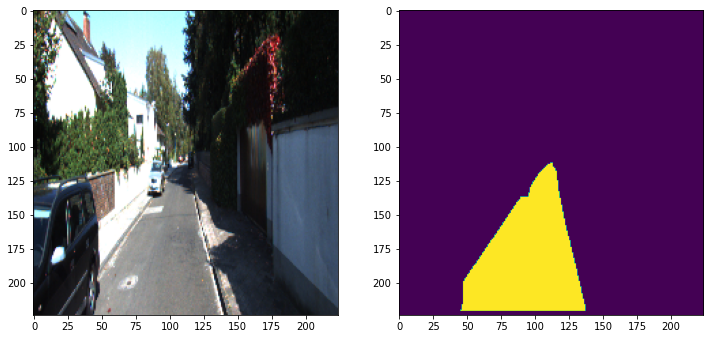

In [8]:
import random
import numpy as np
image_number = random.randint(0, len(image_data))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_data[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# creat model vgg

In [ ]:
!pip install segmentation_models

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import UpSampling2D,Concatenate,Conv2D,Input
from tensorflow.keras.metrics import MeanIoU
from keras.models import Model
from keras import backend as K
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [10]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [21]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  
metrics=['accuracy', jacard_coef]

In [12]:
input=Input(shape=(224,224,3))
vgg=VGG16(weights='imagenet',include_top=False,input_tensor=input)

c1=vgg.get_layer('block3_pool').output
c2=vgg.get_layer('block4_pool').output
c3=vgg.get_layer('block5_pool').output

u1=UpSampling2D((2,2),interpolation='bilinear')(c3)
d1=Concatenate()([u1,c2])
d1=Conv2D(256,1,activation='sigmoid')(d1)

u2=UpSampling2D((2,2),interpolation='bilinear')(d1)
d2=Concatenate()([u2,c1])
d2=Conv2D(256,1,activation='sigmoid')(d2)

u3=UpSampling2D((8,8),interpolation='bilinear')(d2)
outputs=Conv2D(1,1,activation='sigmoid')(u3)

model=Model(input,outputs)

In [22]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [ ]:
history1 = model.fit(image_data, labels, 
                    batch_size = 32, 
                    verbose=1,
                    validation_split=0.25, 
                    epochs=20)

In [24]:
model.save('road_model.h5')